# Slice sampling with covariances matched to slice covariance
This notebook describes how to use a method of slice sampling introduced in [1] to generate MCMC samples from a given target distribution. Unlike most other variants of slice sampling, this approach uses sensitivities to guide the sampler back towards a slice (an area of parameter space where the target density exceeds a given value).

[1] "Covariance-adaptive slice sampling", 2010. Thompson, M and Neal, RM, arXiv preprint arXiv:1003.3201.

# Problem 1: Multimodal Distribution

In experimenting, we found that this type of slice sampling was surprisingly effective at sampling from multimodal distributions. Here, we demonstrate this. First, we plot the multimodal target.

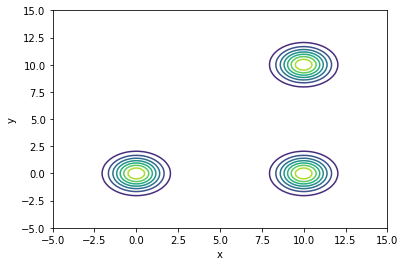

In [1]:
import os
os.chdir("../../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Define target
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes = [[0, 0], [10, 10], [10, 0]])

# Plot target
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Next we use this method of slice sampling to generate MCMC samples from this distribution.

In [4]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [8, 8], size=(4, 2))
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceCovarianceMatchingMCMC)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(5)

# Set maximum number of iterations
mcmc.set_max_iterations(2000)

# Disable logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(20)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Covariance-Adaptive: Covariance Matching
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     4       0:00.0
1     24      0:00.0
2     84      0:00.1
3     88      0:00.1
20    612     0:00.6
40    1132    0:01.2
60    1628    0:01.7
80    2220    0:02.3
100   2836    0:02.9
120   3412    0:03.5


KeyboardInterrupt: 

Overlaying the samples on the modes, we see good coverage across them.

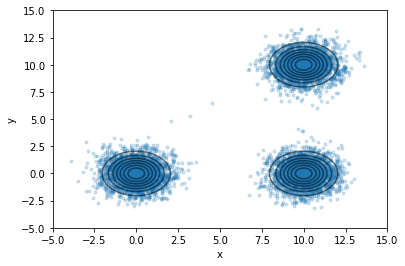

In [6]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

And a low KL divergence from the target at each mode.

In [7]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [0.00070219 0.00122926 0.00132544]


# Problem 2: Simple harmonic oscillator
We now try the same method on a more realistic time-series problem using the [simple harmonic oscillator](../toy/model-simple-harmonic-oscillator.ipynb). model

Plot model solutions with additive noise.

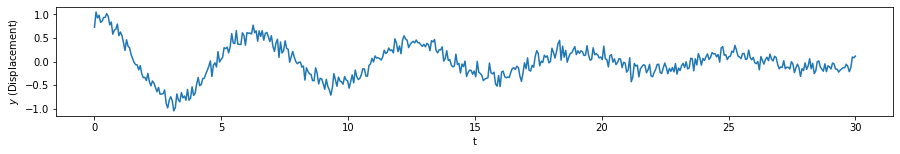

In [6]:
import pints.noise
model = pints.toy.SimpleHarmonicOscillatorModel()

times = np.linspace(0, 30, 500)
parameters = model.suggested_parameters()
values = model.simulate(parameters, times)
values += + pints.noise.independent(0.1, values.shape)

plt.figure(figsize=(15,2))
plt.xlabel('t')
plt.ylabel(r'$y$ (Displacement)')
plt.plot(times, values)
plt.show()

In [12]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [-10, -10, 0, 0],
    [10, 10, 10, 20],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 1
# log_prior.sample(num_chains)
xs = np.array([[ 2.70601259, -3.76849432,  0.04782399,  0.53750962]])

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceCovarianceMatchingMCMC)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(5)
    
# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Covariance-Adaptive: Covariance Matching
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     1       0:00.0
1     2       0:00.0
2     13      0:00.0


KeyboardInterrupt: 

In [14]:
R=np.diag(np.ones(4) * 2.82)
np.dot(np.linalg.inv(R), np.transpose(
            np.linalg.inv(R)))

array([[0.1257482, 0.       , 0.       , 0.       ],
       [0.       , 0.1257482, 0.       , 0.       ],
       [0.       , 0.       , 0.1257482, 0.       ],
       [0.       , 0.       , 0.       , 0.1257482]])

R-hat:


ZeroDivisionError: float division by zero

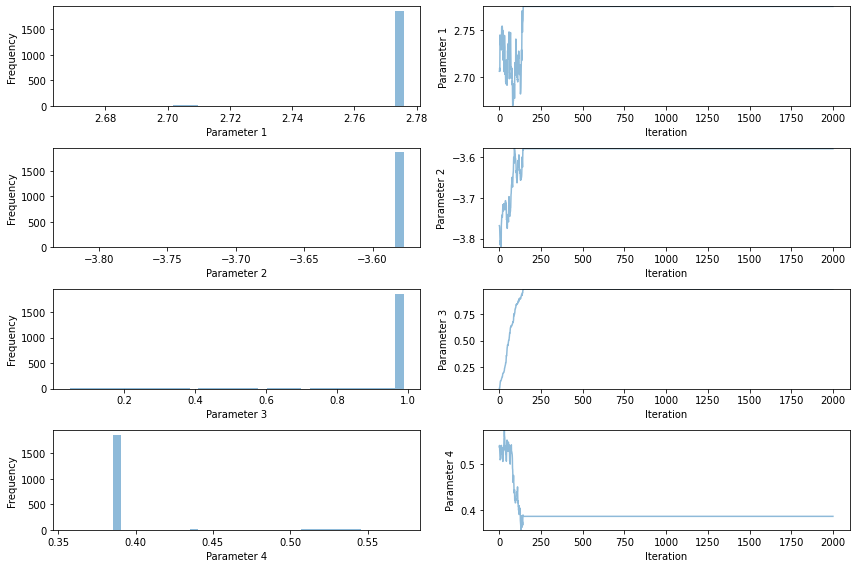

In [4]:
import pints.plot

# Show traces and histograms
pints.plot.trace(full_chains)

# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True, ref_parameters = real_parameters)

# Show graphs
plt.show()